In [ ]:
from google.colab import drive
from pathlib import Path

if 'google.colab' in str(get_ipython()):
    drive.mount('/content/drive')
    base_folder = Path('/content/drive/MyDrive/Colab Notebooks/BUAN 6382')
    models_folder = base_folder / "models"  # Subfolder for saving models
    models_folder.mkdir(parents=True, exist_ok=True)  # Create folder if it doesn't exist

Mounted at /content/drive


In [ ]:
import string

def enhanced_clean_text(text):
    # Step 1: Find the actual start of the content (e.g., "Chapter 1")
    start_marker = "BOOK ONE: 1805"
    start = text.lower().find(start_marker)
    if start != -1:
        text = text[start:]

    # Step 2: Remove URLs and metadata
    text = ' '.join([word for word in text.split() if not word.startswith('http')])

    # Step 3: Remove special formatting markers and transcriber notes
    text = text.replace('_', '')  # Remove underscores
    text = text.replace('^', '')  # Remove carat markers
    text = text.replace('{', '').replace('}', '')  # Remove curly brackets

    # Step 4: Remove punctuation, numbers, and convert to lowercase
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])  # Remove numbers
    text = text.lower()  # Convert to lowercase

    # Step 5: Remove extra spaces
    text = ' '.join(text.split())  # Remove redundant spaces

    return text

# Load raw text file
with open("War and Peace.txt", "r", encoding="utf-8") as file:
    raw_text = file.read()

# Apply the cleaning function
cleaned_text = enhanced_clean_text(raw_text)

# Output the first 500 characters of the cleaned text
print(cleaned_text[:500])

war and peace by leo tolstoytolstoi contents book one chapter i chapter ii chapter iii chapter iv chapter v chapter vi chapter vii chapter viii chapter ix chapter x chapter xi chapter xii chapter xiii chapter xiv chapter xv chapter xvi chapter xvii chapter xviii chapter xix chapter xx chapter xxi chapter xxii chapter xxiii chapter xxiv chapter xxv chapter xxvi chapter xxvii chapter xxviii book two chapter i chapter ii chapter iii chapter iv chapter v chapter vi chapter vii chapter viii chapter i


In [ ]:
import numpy as np

# Tokenize the text at character level
chars = sorted(set(cleaned_text))  # Unique characters
char_to_index = {char: idx for idx, char in enumerate(chars)}  # Character to integer mapping
index_to_char = {idx: char for idx, char in enumerate(chars)}  # Integer to character mapping

# Convert text into integers
text_as_int = np.array([char_to_index[char] for char in cleaned_text])

# Define sequence length and prepare input-output pairs
sequence_length = 100
sequences = []
targets = []

for i in range(len(text_as_int) - sequence_length):
    sequences.append(text_as_int[i:i+sequence_length])
    targets.append(text_as_int[i+sequence_length])

sequences = np.array(sequences)
targets = np.array(targets)

In [ ]:
len(sequences)

3096990

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# Split data into training and validation sets
train_size = int(0.9 * len(sequences))
val_size = len(sequences) - train_size

train_dataset = TextDataset(sequences[:train_size], targets[:train_size])
val_dataset = TextDataset(sequences[train_size:], targets[train_size:])

In [ ]:
import matplotlib.pyplot as plt
import torch

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """
    Train the given model and visualize training and validation loss over epochs.

    Args:
        model: The PyTorch model to train.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        criterion: Loss function.
        optimizer: Optimizer for training.
        num_epochs: Number of training epochs.
        device: Device to train on (e.g., "cpu" or "cuda").

    Returns:
        model: Trained model (last epoch).
        best_model_state_dict: State dictionary of the model with the best validation loss.
        train_losses: List of training losses for each epoch.
        val_losses: List of validation losses for each epoch.
    """
    # Move model to the device
    model.to(device)

    # Calculate the number of trainable parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total number of trainable parameters in the model: {total_params}")

    # Lists to store losses
    train_losses = []
    val_losses = []

    # Best validation loss and model
    best_val_loss = float('inf')
    best_model_state_dict = None

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs, _ = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs, _ = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # Calculate average losses for the epoch
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        # Store losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Check for best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state_dict = model.state_dict()  # Save the state dict of the best model

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Plot the training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0)  # Start y-axis from 0
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return the model and the best model state dict
    return model, best_model_state_dict, train_losses, val_losses


In [ ]:
def generate_text(model, seed_text, length):
    model.eval()  # Set the model to evaluation mode
    generated_text = seed_text
    hidden = None

    for _ in range(length):
        # Convert seed text to integers
        input_seq = torch.tensor([char_to_index[char] for char in seed_text[-sequence_length:]], dtype=torch.long).unsqueeze(0).to(device)

        # Get predictions
        with torch.no_grad():
            output, hidden = model(input_seq, hidden)  # Forward pass
            output = output.squeeze(0)  # Remove batch dimension
            next_char_index = torch.argmax(output).item()  # Select the most probable character deterministically

        # Append the predicted character
        next_char = index_to_char[next_char_index]
        generated_text += next_char
        seed_text += next_char

    return generated_text

In [ ]:
# Load the saved model and generate text
def load_model(model_class, model_path, vocab_size, embed_size, hidden_size, num_layers, dropout_rate, device):
    """
    Load the saved model state dictionary into a model instance.

    Args:
        model_class: The class definition of the model.
        model_path: Path to the saved model file.
        vocab_size: Size of the vocabulary.
        embed_size: Size of the embedding layer.
        hidden_size: Size of the hidden state.
        num_layers: Number of LSTM layers.
        dropout_rate: Dropout rate.
        device: Device to load the model on ("cpu" or "cuda").

    Returns:
        model: Loaded model ready for inference.
    """
    # Instantiate the model
    model = model_class(vocab_size, embed_size, hidden_size, num_layers, dropout_rate)
    model.load_state_dict(torch.load(model_path, map_location=device))  # Load state dictionary
    model.to(device)  # Move to device
    model.eval()  # Set to evaluation mode
    print(f"Model loaded from {model_path}")
    return model

In [ ]:
import math

def calculate_perplexity(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_count = 0
    criterion = nn.CrossEntropyLoss()  # Loss function used for training

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, _ = model(inputs)  # Get model predictions
            loss = criterion(outputs, targets)  # Compute loss
            total_loss += loss.item() * inputs.size(0)  # Accumulate loss
            total_count += inputs.size(0)  # Count tokens

    # Calculate perplexity
    average_loss = total_loss / total_count
    perplexity = math.exp(average_loss)
    return perplexity

In [ ]:
from collections import Counter

def calculate_entropy(generated_text):
    # Count the frequency of each character
    char_counts = Counter(generated_text)
    total_chars = sum(char_counts.values())

    # Compute entropy
    entropy = -sum((count / total_chars) * math.log2(count / total_chars) for count in char_counts.values())
    return entropy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


##Model 0_1 Basic

Single layer LSTM.

Training Sequence Length 100

Hidden size 128

Character level Embedding size 128

Batch Size 1024

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024)

In [ ]:
len(train_loader)

2722

Total number of trainable parameters in the model: 144175
Epoch 1/20, Train Loss: 1.6690, Val Loss: 1.5028
Epoch 2/20, Train Loss: 1.3958, Val Loss: 1.4105
Epoch 3/20, Train Loss: 1.3303, Val Loss: 1.3750
Epoch 4/20, Train Loss: 1.2957, Val Loss: 1.3563
Epoch 5/20, Train Loss: 1.2732, Val Loss: 1.3409
Epoch 6/20, Train Loss: 1.2569, Val Loss: 1.3264
Epoch 7/20, Train Loss: 1.2442, Val Loss: 1.3159
Epoch 8/20, Train Loss: 1.2340, Val Loss: 1.3127
Epoch 9/20, Train Loss: 1.2258, Val Loss: 1.3068
Epoch 10/20, Train Loss: 1.2186, Val Loss: 1.3012
Epoch 11/20, Train Loss: 1.2126, Val Loss: 1.2973
Epoch 12/20, Train Loss: 1.2073, Val Loss: 1.2920
Epoch 13/20, Train Loss: 1.2025, Val Loss: 1.2913
Epoch 14/20, Train Loss: 1.1986, Val Loss: 1.2876
Epoch 15/20, Train Loss: 1.1948, Val Loss: 1.2831
Epoch 16/20, Train Loss: 1.1914, Val Loss: 1.2842
Epoch 17/20, Train Loss: 1.1884, Val Loss: 1.2830
Epoch 18/20, Train Loss: 1.1856, Val Loss: 1.2804
Epoch 19/20, Train Loss: 1.1829, Val Loss: 1.2783
E

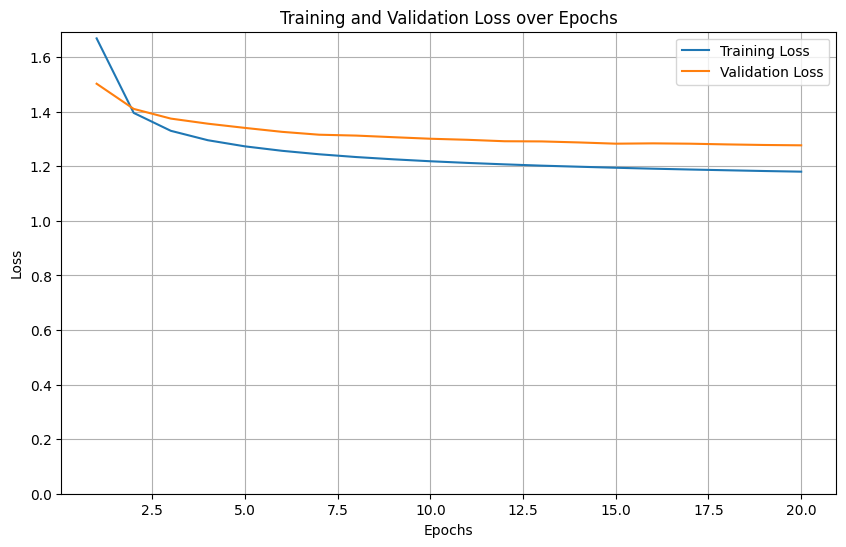

Last epoch model saved to /content/drive/MyDrive/Colab Notebooks/BUAN 6382/models/lstm_model0_1.pth
Best validation loss model saved to /content/drive/MyDrive/Colab Notebooks/BUAN 6382/models/lstm_model0_1_best.pth


In [ ]:
import torch.nn as nn
import torch.optim as optim

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, dropout=0):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.dropout = nn.Dropout(dropout)  # Dropout after LSTM output
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)  # Convert input to embeddings
        output, hidden = self.lstm(x, hidden)  # Pass through LSTM layers
        output = self.dropout(output)  # Apply dropout to LSTM outputs
        output = self.fc(output[:, -1, :])  # Use the last output for prediction
        return output, hidden

# Define model parameters
vocab_size = len(chars)
embed_size = 128
hidden_size = 128

model0_1 = LSTMModel(vocab_size, embed_size, hidden_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer0_1 = optim.Adam(model0_1.parameters(), lr=0.001)

# Train the model
trained_model0_1, best_model_state_dict0_1, train_losses, val_losses = train_model(
    model0_1, train_loader, val_loader, criterion, optimizer0_1, num_epochs=20, device=device
)

# Save the last epoch model
last_epoch_model_path = models_folder / "lstm_model0_1.pth"
torch.save(trained_model0_1.state_dict(), last_epoch_model_path)
print(f"Last epoch model saved to {last_epoch_model_path}")

# Save the best model based on validation loss
best_model_path = models_folder / "lstm_model0_1_best.pth"
torch.save(best_model_state_dict0_1, best_model_path)
print(f"Best validation loss model saved to {best_model_path}")

In [ ]:
# Define model parameters
model_path = models_folder / "lstm_model0_1.pth"
vocab_size = len(chars)
embed_size = 128
hidden_size = 128
num_layers = 1
dropout_rate = 0

model0_1 = load_model(LSTMModel, model_path, vocab_size, embed_size, hidden_size, num_layers, dropout_rate, device)

Model loaded from /content/drive/MyDrive/Colab Notebooks/BUAN 6382/models/lstm_model0_1.pth


<ipython-input-8-fbad9d1571da>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))  # Load state dictionary


In [ ]:
seed_text = "The soldiers marched forward and at a".lower()  # Convert to lowercase
generated_text = generate_text(model0_1, seed_text, length=200)
print(generated_text)

the soldiers marched forward and at a strange and the street the count and the count and the count and the count and the count and the count and the count and the count and the count and the count and the count and the count and the coun


In [ ]:
# Evaluate perplexity on the validation set
val_perplexity = calculate_perplexity(model0_1, val_loader)
print(f"Validation Perplexity: {val_perplexity:.2f}")

entropy = calculate_entropy(generated_text)
print(f"Entropy of Generated Text: {entropy:.2f}")

Validation Perplexity: 3.58
Entropy of Generated Text: 3.50


## Model1_1:

Single layer LSTM.

Training Sequence Length 100

Hidden size 512

Character level Embedding size 128

Batch Size 512

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=2096, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2096)

In [ ]:
len(train_loader)

1330

Total number of trainable parameters in the model: 1344943
Epoch 1/20, Train Loss: 1.4945, Val Loss: 1.3245
Epoch 2/20, Train Loss: 1.1998, Val Loss: 1.2423
Epoch 3/20, Train Loss: 1.1324, Val Loss: 1.2124
Epoch 4/20, Train Loss: 1.0942, Val Loss: 1.1945
Epoch 5/20, Train Loss: 1.0679, Val Loss: 1.1865
Epoch 6/20, Train Loss: 1.0474, Val Loss: 1.1796
Epoch 7/20, Train Loss: 1.0305, Val Loss: 1.1783
Epoch 8/20, Train Loss: 1.0160, Val Loss: 1.1776
Epoch 9/20, Train Loss: 1.0033, Val Loss: 1.1755
Epoch 10/20, Train Loss: 0.9920, Val Loss: 1.1768
Epoch 11/20, Train Loss: 0.9817, Val Loss: 1.1773
Epoch 12/20, Train Loss: 0.9723, Val Loss: 1.1795
Epoch 13/20, Train Loss: 0.9639, Val Loss: 1.1830
Epoch 14/20, Train Loss: 0.9561, Val Loss: 1.1865
Epoch 15/20, Train Loss: 0.9489, Val Loss: 1.1848
Epoch 16/20, Train Loss: 0.9423, Val Loss: 1.1913
Epoch 17/20, Train Loss: 0.9365, Val Loss: 1.1954
Epoch 18/20, Train Loss: 0.9306, Val Loss: 1.1976
Epoch 19/20, Train Loss: 0.9257, Val Loss: 1.1994


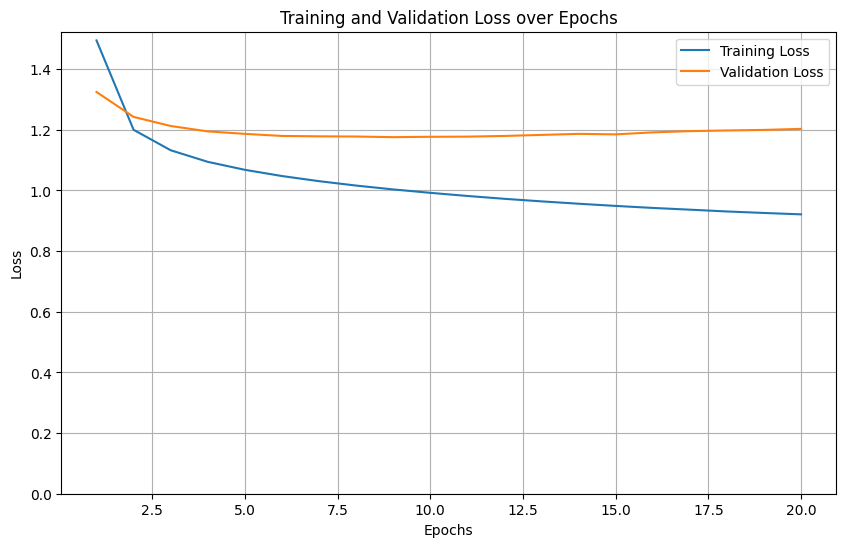

Last epoch model saved to /content/drive/MyDrive/Colab Notebooks/BUAN 6382/models/lstm_model1_1.pth
Best validation loss model saved to /content/drive/MyDrive/Colab Notebooks/BUAN 6382/models/lstm_model1_1_best.pth


In [ ]:
# Define the LSTM model
class LSTMModel1(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, dropout=0):
        super(LSTMModel1, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.dropout = nn.Dropout(dropout)  # Dropout after LSTM output
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)  # Convert input to embeddings
        output, hidden = self.lstm(x, hidden)  # Pass through LSTM layers
        output = self.dropout(output)  # Apply dropout to LSTM outputs
        output = self.fc(output[:, -1, :])  # Use the last output for prediction
        return output, hidden

# Define model parameters
vocab_size = len(chars)
embed_size = 128
hidden_size = 512

model1_1 = LSTMModel1(vocab_size, embed_size, hidden_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer1_1 = optim.Adam(model1_1.parameters(), lr=0.001)

# Train the model
trained_model1_1, best_model_state_dict1_1, train_losses, val_losses = train_model(
    model1_1, train_loader, val_loader, criterion, optimizer1_1, num_epochs=20, device=device
)

# Save the last epoch model
last_epoch_model_path = models_folder / "lstm_model1_1.pth"
torch.save(trained_model1_1.state_dict(), last_epoch_model_path)
print(f"Last epoch model saved to {last_epoch_model_path}")

# Save the best model based on validation loss
best_model_path = models_folder / "lstm_model1_1_best.pth"
torch.save(best_model_state_dict1_1, best_model_path)
print(f"Best validation loss model saved to {best_model_path}")

In [ ]:
# Define model parameters
model_path = models_folder / "lstm_model1_1_best.pth"
vocab_size = len(chars)
embed_size = 128
hidden_size = 512
num_layers = 1
dropout_rate = 0

model1_1 = load_model(LSTMModel1, model_path, vocab_size, embed_size, hidden_size, num_layers, dropout_rate, device)

Model loaded from /content/drive/MyDrive/Colab Notebooks/BUAN 6382/models/lstm_model1_1_best.pth


<ipython-input-8-fbad9d1571da>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))  # Load state dictionary


In [ ]:
seed_text = "The soldiers marched forward and at a".lower()  # Convert to lowercase
generated_text = generate_text(model1_1, seed_text, length=200)
print(generated_text)

the soldiers marched forward and at a distance which was already at the same time and the countess was a significance of the conversation with his hand and said to him and the countess was a significance of the commander in chiefs attemp


In [ ]:
# Evaluate perplexity on the validation set
val_perplexity = calculate_perplexity(model1_1, val_loader)
print(f"Validation Perplexity: {val_perplexity:.2f}")

entropy = calculate_entropy(generated_text)
print(f"Entropy of Generated Text: {entropy:.2f}")

Validation Perplexity: 3.33
Entropy of Generated Text: 3.88


# BEST MODEL: Retrain with LR Scheduler.

## Model2_1:

Single layer LSTM.

Training Sequence Length 100

Hidden size 1024

Character level Embedding size 128

Batch Size 2096

Total number of trainable parameters in the model: 4780975
Epoch 1/20, Train Loss: 1.3807, Val Loss: 1.2379
Epoch 2/20, Train Loss: 1.1153, Val Loss: 1.1818
Epoch 3/20, Train Loss: 1.0514, Val Loss: 1.1572
Epoch 4/20, Train Loss: 1.0087, Val Loss: 1.1443
Epoch 5/20, Train Loss: 0.9748, Val Loss: 1.1451
Epoch 6/20, Train Loss: 0.9464, Val Loss: 1.1481
Epoch 7/20, Train Loss: 0.9214, Val Loss: 1.1527
Epoch 8/20, Train Loss: 0.9000, Val Loss: 1.1584
Epoch 9/20, Train Loss: 0.8817, Val Loss: 1.1750
Epoch 10/20, Train Loss: 0.8670, Val Loss: 1.1797
Epoch 11/20, Train Loss: 0.8544, Val Loss: 1.1924
Epoch 12/20, Train Loss: 0.8448, Val Loss: 1.1995
Epoch 13/20, Train Loss: 0.8387, Val Loss: 1.2064
Epoch 14/20, Train Loss: 0.8342, Val Loss: 1.2179
Epoch 15/20, Train Loss: 0.8318, Val Loss: 1.2246
Epoch 16/20, Train Loss: 0.8332, Val Loss: 1.2311
Epoch 17/20, Train Loss: 0.8345, Val Loss: 1.2329
Epoch 18/20, Train Loss: 0.8392, Val Loss: 1.2333
Epoch 19/20, Train Loss: 0.8446, Val Loss: 1.2374


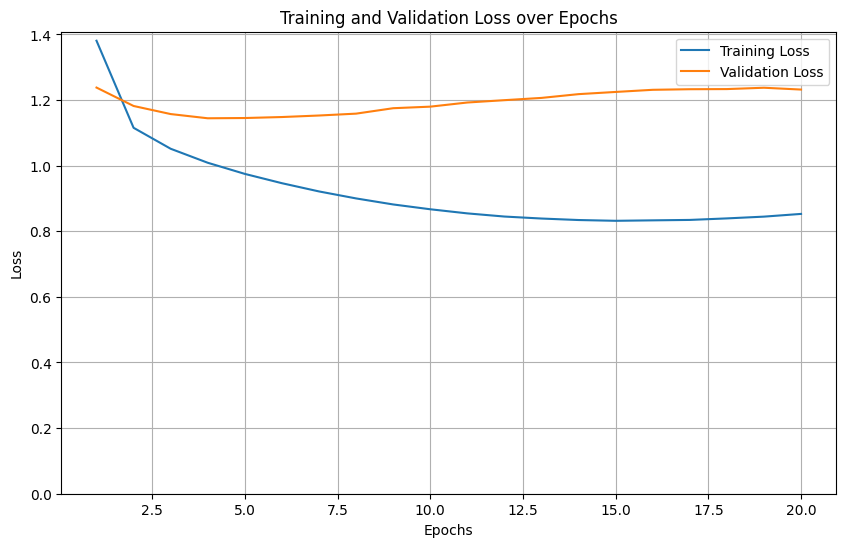

Last epoch model saved to /content/drive/MyDrive/Colab Notebooks/BUAN 6382/models/lstm_model2_1.pth
Best validation loss model saved to /content/drive/MyDrive/Colab Notebooks/BUAN 6382/models/lstm_model2_1_best.pth


In [ ]:
# Define the LSTM model
class LSTMModel2(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, dropout=0):
        super(LSTMModel2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.dropout = nn.Dropout(dropout)  # Dropout after LSTM output
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)  # Convert input to embeddings
        output, hidden = self.lstm(x, hidden)  # Pass through LSTM layers
        output = self.dropout(output)  # Apply dropout to LSTM outputs
        output = self.fc(output[:, -1, :])  # Use the last output for prediction
        return output, hidden

# Define model parameters
vocab_size = len(chars)
embed_size = 128
hidden_size = 1024

model2_1 = LSTMModel2(vocab_size, embed_size, hidden_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer2_1 = optim.Adam(model2_1.parameters(), lr=0.001)

# Train the model
trained_model2_1, best_model_state_dict2_1, train_losses, val_losses = train_model(
    model2_1, train_loader, val_loader, criterion, optimizer2_1, num_epochs=20, device=device
)

# Save the last epoch model
last_epoch_model_path = models_folder / "lstm_model2_1.pth"
torch.save(trained_model2_1.state_dict(), last_epoch_model_path)
print(f"Last epoch model saved to {last_epoch_model_path}")

# Save the best model based on validation loss
best_model_path = models_folder / "lstm_model2_1_best.pth"
torch.save(best_model_state_dict2_1, best_model_path)
print(f"Best validation loss model saved to {best_model_path}")

In [ ]:
# Define model parameters
model_path = models_folder / "lstm_model2_1_best.pth"
vocab_size = len(chars)
embed_size = 128
hidden_size = 1024
num_layers = 1
dropout_rate = 0

model1_1 = load_model(LSTMModel1, model_path, vocab_size, embed_size, hidden_size, num_layers, dropout_rate, device)

Model loaded from /content/drive/MyDrive/Colab Notebooks/BUAN 6382/models/lstm_model2_1_best.pth


<ipython-input-8-fbad9d1571da>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))  # Load state dictionary


In [ ]:
seed_text = "The soldiers marched forward and at a".lower()  # Convert to lowercase
generated_text = generate_text(model1_1, seed_text, length=200)
print(generated_text)

the soldiers marched forward and at any moment the count was sent to him and the count was sent to her so far said the count who was sitting in the corner of the street the count was seriously as if in any pained hole in his hand and she


In [ ]:
# Evaluate perplexity on the validation set
val_perplexity = calculate_perplexity(model2_1, val_loader)
print(f"Validation Perplexity: {val_perplexity:.2f}")

entropy = calculate_entropy(generated_text)
print(f"Entropy of Generated Text: {entropy:.2f}")

Validation Perplexity: 3.42
Entropy of Generated Text: 3.82


## Model4:

Two layer LSTM.

Hidden size 512

Character level Embedding size 128

Batch Size 3200

Dropout 0.5

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=3200, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=3200)

In [ ]:
import torch.nn as nn
import torch.optim as optim

class LSTMModel4(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, dropout=0.5):
        super(LSTMModel4, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.dropout = nn.Dropout(dropout)  # Dropout after LSTM output
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)  # Convert input to embeddings
        output, hidden = self.lstm(x, hidden)  # Pass through LSTM layers
        output = self.dropout(output)  # Apply dropout to LSTM outputs
        output = self.fc(output[:, -1, :])  # Use the last output for prediction
        return output, hidden

Total number of trainable parameters in the model: 3446191
Epoch 1/20, Train Loss: 1.6630, Val Loss: 1.3491
Epoch 2/20, Train Loss: 1.3162, Val Loss: 1.2592
Epoch 3/20, Train Loss: 1.2408, Val Loss: 1.2207
Epoch 4/20, Train Loss: 1.2012, Val Loss: 1.1976
Epoch 5/20, Train Loss: 1.1753, Val Loss: 1.1858
Epoch 6/20, Train Loss: 1.1570, Val Loss: 1.1727
Epoch 7/20, Train Loss: 1.1443, Val Loss: 1.1699
Epoch 8/20, Train Loss: 1.1312, Val Loss: 1.1575
Epoch 9/20, Train Loss: 1.1208, Val Loss: 1.1530
Epoch 10/20, Train Loss: 1.1115, Val Loss: 1.1506
Epoch 11/20, Train Loss: 1.1051, Val Loss: 1.1489
Epoch 12/20, Train Loss: 1.0989, Val Loss: 1.1452
Epoch 13/20, Train Loss: 1.0934, Val Loss: 1.1431
Epoch 14/20, Train Loss: 1.0887, Val Loss: 1.1426
Epoch 15/20, Train Loss: 1.0836, Val Loss: 1.1379
Epoch 16/20, Train Loss: 1.0795, Val Loss: 1.1357
Epoch 17/20, Train Loss: 1.0763, Val Loss: 1.1319
Epoch 18/20, Train Loss: 1.0725, Val Loss: 1.1331
Epoch 19/20, Train Loss: 1.0707, Val Loss: 1.1305


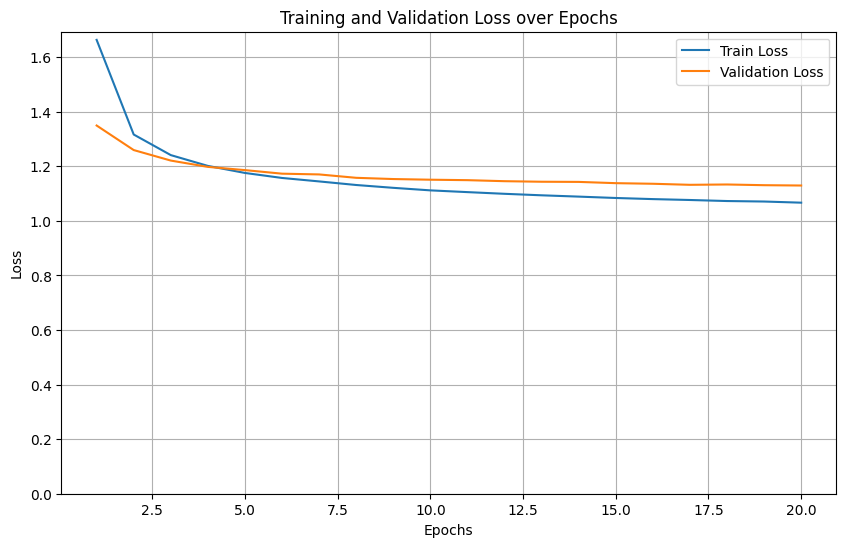

Model saved to /content/drive/MyDrive/Colab Notebooks/BUAN 6382/models/lstm_model4.pth


In [ ]:
import torch.nn as nn
import torch.optim as optim

class LSTMModel4(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, dropout=0.5):
        super(LSTMModel4, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.dropout = nn.Dropout(dropout)  # Dropout after LSTM output
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)  # Convert input to embeddings
        output, hidden = self.lstm(x, hidden)  # Pass through LSTM layers
        output = self.dropout(output)  # Apply dropout to LSTM outputs
        output = self.fc(output[:, -1, :])  # Use the last output for prediction
        return output, hidden

# Define model parameters
vocab_size = len(chars)
embed_size = 128
hidden_size = 512
num_layers = 2
dropout_rate = 0.5

# Instantiate the model with dropout
model4 = LSTMModel4(vocab_size, embed_size, hidden_size, num_layers, dropout=dropout_rate)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer4 = optim.Adam(model4.parameters(), lr=0.001)

# Train the model
trained_model, train_losses, val_losses = train_model(
    model4, train_loader, val_loader, criterion, optimizer4, num_epochs=20, device=device
)

# Save the model to Google Drive
model_save_path = models_folder / "lstm_model4.pth"
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

In [ ]:
def train_model_continue(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, start_epoch=1):
    """
    Train or continue training a given model and visualize training and validation loss over epochs.

    Args:
        model: The PyTorch model to train.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        criterion: Loss function.
        optimizer: Optimizer for training.
        num_epochs: Number of total training epochs.
        device: Device to train on (e.g., "cpu" or "cuda").
        start_epoch: The epoch number to start training from (default is 1).

    Returns:
        model: Trained model (last epoch).
        best_model_state_dict: State dictionary of the model with the best validation loss.
        train_losses: List of training losses for each epoch.
        val_losses: List of validation losses for each epoch.
    """
    # Move model to the device
    model.to(device)

    # Calculate the number of trainable parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total number of trainable parameters in the model: {total_params}")

    # Lists to store losses
    train_losses = []
    val_losses = []

    # Best validation loss and model
    best_val_loss = float('inf')
    best_model_state_dict = None

    # Training loop
    for epoch in range(start_epoch, num_epochs + 1):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs, _ = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs, _ = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # Calculate average losses for the epoch
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        # Store losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Check for best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state_dict = model.state_dict()  # Save the state dict of the best model

        print(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Return the model and the best model state dict
    return model, best_model_state_dict, train_losses, val_losses



In [ ]:
def continue_training(model, checkpoint_path, train_loader, val_loader, criterion, optimizer, start_epoch, end_epoch, device):
    """
    Continue training a saved model from a given checkpoint.

    Args:
        model: The PyTorch model to train.
        checkpoint_path: Path to the saved model checkpoint.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        criterion: Loss function.
        optimizer: Optimizer for training.
        start_epoch: The epoch number to resume training from.
        end_epoch: The epoch number to stop training at.
        device: Device to train on (e.g., "cpu" or "cuda").
    """
    # Load the checkpoint
    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)
    print(f"Resuming training from epoch {start_epoch}...")

    # Continue training
    return train_model_continue(model, train_loader, val_loader, criterion, optimizer, end_epoch, device, start_epoch=start_epoch)

optimizer4 = optim.Adam(model4.parameters(), lr=0.0002)

# Example usage:
# Assuming `model4`, `train_loader`, and `val_loader` are defined
checkpoint_path = model_save_path
trained_model, best_model_state, train_losses, val_losses = continue_training(
    model4,
    checkpoint_path,
    train_loader,
    val_loader,
    criterion,
    optimizer4,
    start_epoch=20,
    end_epoch=30,
    device=device
)

# Save the final model
torch.save(trained_model.state_dict(), models_folder / "lstm_model4_epoch30.pth")
print("Final model saved as 'lstm_model_final.pth'")

<ipython-input-15-99fe665b7b62>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Resuming training from epoch 20...
Total number of trainable parameters in the model: 3446191
Epoch 20/30, Train Loss: 1.0391, Val Loss: 1.1238


KeyboardInterrupt: 

In [ ]:
# Model parameters
model_path = models_folder / "lstm_model4.pth"
vocab_size = len(chars)
embed_size = 128
hidden_size = 512
num_layers = 2
dropout_rate = 0.5

# Load the model
model4 = load_model(LSTMModel4, model_path, vocab_size, embed_size, hidden_size, num_layers, dropout_rate, device)

seed_text = "The soldiers marched forward and at a".lower()  # Convert to lowercase
generated_text = generate_text(model4, seed_text, length=200)
print(generated_text)

<ipython-input-9-fbad9d1571da>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))  # Load state dictionary


Model loaded from /content/drive/MyDrive/Colab Notebooks/BUAN 6382/models/lstm_model4.pth
the soldiers marched forward and at a state of the staff of the staff of the staff of the staff of the staff of the street the count was a stranger and the same thing the count was a stranger and the same thing the count was a stranger a


In [ ]:
# Evaluate perplexity on the validation set
val_perplexity = calculate_perplexity(model4, val_loader)
print(f"Validation Perplexity: {val_perplexity:.2f}")

entropy = calculate_entropy(generated_text)
print(f"Entropy of Generated Text: {entropy:.2f}")